In [33]:
import numpy as np
import pandas as pd

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.models import Committee
from modAL.disagreement import vote_entropy_sampling


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
import xgboost as xgb

import recordlinkage as rl

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df_uns = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\df_uns_label.csv')
df_full = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\merged_clean_df.csv')
df_full.drop('Unnamed: 0',axis=1,inplace=True)

#Manually annotated data
test_1 = rl.read_annotation_file(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\Double-Listing\Data\result_bnb_trip.json')
test_2 = rl.read_annotation_file(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\Double-Listing\Data\result_bnb_vrb.json')

In [20]:
df_full.columns.values.reshape(1, 66)
df_full.values

array([['site', 'ListingId', 'Name', 'postalcode', 'Bedrooms',
        'Bathrooms', 'Beds', 'Person_capacity', 'Host_first_name',
        'Host_picture_url', 'Instant_bookable', 'Is_new_listing',
        'Neighborhood', 'Lat', 'Lng', 'Picture_url', 'reviews_count',
        'Room_type_category', 'Room_type', 'Space_type', 'booking_count',
        'host_listings_count_hist', 'kpi_capacity_more_than_4',
        'kpi_capacity_more_than_6', 'kpi_instant_bookable',
        'kpi_host_lists_multiple', 'kpi_host_lists_10_or_more',
        'days_active', 'host_start_year', 'host_start_month',
        'reviews_year', 'reviews_6_months', 'reviews_3_months',
        'reviews_1_month', 'rating_avg', 'bad_ratings_count',
        'year_total_available', '2021-08_available_days',
        '2021-09_available_days', '2021-10_available_days',
        '2021-11_available_days', '2021-12_available_days',
        '2022-02_available_days', '2022-03_available_days',
        '2022-04_available_days', '2022-05_ava

In [22]:
def compare(df,id_1,id_2):
    #Compare URLS
    col = df_full.columns.values.reshape(1, 66)
    link = [x for x in df_full['listing_url'][df_full['ListingId']==id_1]]
    link_4 = df[df['ListingId']==id_1].values
    link_2 = [x for x in df_full['listing_url'][df_full['ListingId']==id_2]]
     
    link_3 = df[df['ListingId']==id_2].values
    link_3= np.concatenate((col, link_3), axis=0).T
    link_4= np.concatenate((col, link_4), axis=0).T
    return link[0],link_2[0], link_4, link_3

compare(df_full,10161202, 10161074)

('https://www.airbnb.nl/rooms/10161202',
 'https://www.airbnb.nl/rooms/10161074',
 array([['site', 'AIRBNB'],
        ['ListingId', 10161202],
        ['Name', 'Hotel Jansen Amsterdam Vondel 0.17'],
        ['postalcode', nan],
        ['Bedrooms', 0.0],
        ['Bathrooms', nan],
        ['Beds', nan],
        ['Person_capacity', 2],
        ['Host_first_name', 'Geraldine'],
        ['Host_picture_url', nan],
        ['Instant_bookable', 0],
        ['Is_new_listing', 0],
        ['Neighborhood', 'zuid'],
        ['Lat', 52.3415],
        ['Lng', 4.84391],
        ['Picture_url', nan],
        ['reviews_count', nan],
        ['Room_type_category', nan],
        ['Room_type', 'Private room'],
        ['Space_type', nan],
        ['booking_count', nan],
        ['host_listings_count_hist', nan],
        ['kpi_capacity_more_than_4', nan],
        ['kpi_capacity_more_than_6', nan],
        ['kpi_instant_bookable', 0.0],
        ['kpi_host_lists_multiple', nan],
        ['kpi_host_lists_1

In [4]:
#Take out the labeled data for making a test set 
manual_labeled = []

#Getting the Listing Ids bc the files is in index 
for x,y in test_1.links:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),1])
    manual_labeled.append([str(tuple_2),1])
    
for x,y in test_2.links:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),1])
    manual_labeled.append([str(tuple_2),1])
for x,y in test_1.distinct:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),0])
    manual_labeled.append([str(tuple_2),0])
    
for x,y in test_2.distinct:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),0])
    manual_labeled.append([str(tuple_2),0])

 #Merging to have it with the full data   
df_labeled = pd.DataFrame(manual_labeled,columns=['ids','labels'])
df_labeled
with_labels =df_uns.merge(df_labeled,on='ids',how='left')


In [5]:
#Comitee of models
def randomforest():
    clf = RandomForestClassifier(random_state=1)
    return clf
def desiciontree():
    clf= DecisionTreeClassifier(random_state=1)
    return clf
def logisticreg():
    clf = LogisticRegression(random_state=1)
    return clf
def xbg_class():
    clf = xgb.XGBClassifier()
    return clf
def svm():
    clf = SVC(probability=True)
    return clf

In [6]:
#Comitee of models
members = [randomforest,desiciontree,logisticreg,xbg_class,svm]
#List with comitee object
learner_list = list()

#Only use the data corresponding to the features to train
not_train = ['ListingId_1','ListingId_2','ids', 'agg_score', 'weights','uns_label','labels']
ids = with_labels['ids'].values
X_pool = with_labels.drop(not_train, axis=1).values
y_uns_label = with_labels['uns_label'].values
y_uns_weight = with_labels['weights'].values

#Create the test set , select the not nan values
y_test_1= with_labels['labels'].values
idx = np.argwhere(~np.isnan(y_test_1)).reshape(-1)
y_test= y_test_1[idx]
X_test = X_pool[idx]
#Eliminate from the main data variables the test data extracted
X_pool = np.delete(X_pool, np.argwhere(~np.isnan(y_test_1)), axis=0)
y_uns_label = np.delete(y_uns_label, np.argwhere(~np.isnan(y_test_1)), axis=0)
y_uns_weight = np.delete(y_uns_weight, np.argwhere(~np.isnan(y_test_1)), axis=0)
ids = np.delete(ids, np.argwhere(~np.isnan(y_test_1)), axis=0)
 
for clf in members:
    # initial training data
    #Selcting the most confident unsupervised labels for initial training
    train_idx = np.where(y_uns_weight==1)
    
    
    X_train = X_pool[train_idx]
    y_train = y_uns_label[train_idx]

    
    # initializing learner
    learner = ActiveLearner(
        estimator=clf(),
        X_training=X_train, y_training=y_train
    )
    learner_list.append(learner)

# assembling the committee
committee = Committee(learner_list=learner_list,query_strategy=vote_entropy_sampling)

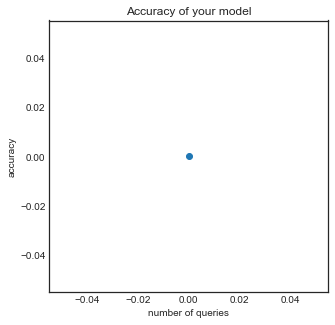

Are this two listings the same one? 1-match , 0-nonmatch
1
('https://www.airbnb.nl/rooms/16865512', 'https://www.airbnb.nl/rooms/13663860', array([['site', 'AIRBNB'],
       ['ListingId', 16865512],
       ['Name', 'Sunshine next to Vondelpark'],
       ['postalcode', nan],
       ['Bedrooms', 0.0],
       ['Bathrooms', nan],
       ['Beds', 2.0],
       ['Person_capacity', 4],
       ['Host_first_name', '??'],
       ['Host_picture_url', nan],
       ['Instant_bookable', 0],
       ['Is_new_listing', 0],
       ['Neighborhood', 'zuid'],
       ['Lat', 52.35237],
       ['Lng', 4.84842],
       ['Picture_url', nan],
       ['reviews_count', nan],
       ['Room_type_category', nan],
       ['Room_type', 'Entire home/apt'],
       ['Space_type', nan],
       ['booking_count', nan],
       ['host_listings_count_hist', nan],
       ['kpi_capacity_more_than_4', nan],
       ['kpi_capacity_more_than_6', nan],
       ['kpi_instant_bookable', 0.0],
       ['kpi_host_lists_multiple', nan],
    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Invitado\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-52-9eeb3bc9de10>", line 29, in <module>
    label = int(input())
ValueError: invalid literal for int() with base 10: ''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Invitado\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Invitado\anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1170, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\Invitado\anaconda3

TypeError: object of type 'NoneType' has no len()

In [52]:
y_pred = committee.predict(X_test)
precision_recall_fscore= precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)

precision_scores = [precision_recall_fscore[0]]
recall_scores=  [precision_recall_fscore[1]]
f_score = [precision_recall_fscore[2]]
new_labels = []

# query by committee
n_queries = 20
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('Accuracy of your model')
        plt.plot(range(idx+1), precision_scores)
        plt.scatter(range(idx+1), precision_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')
        
    print("Are this two listings the same one? 1-match , 0-nonmatch")
    print(len(query_idx))
    ids_int = [int(x) for x in ids[query_idx[0]][1:-1].split(',')]
    print(compare(df_full,ids_int[0],ids_int[1]))
    label = int(input())
    y_new = np.array([label], dtype=int)
    committee.teach(query_instance.reshape(1, -1), y_new)

    X_pool = np.delete(X_pool, query_idx, axis=0)

    y_pred = committee.predict(X_test)
    precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)

    precision_scores.append(precision_recall_fscore[0])
    recall_scores.append(precision_recall_fscore[1])
    f_score.append(precision_recall_fscore[2])
    new_labels.append([(ids_int[0],ids_int[1]),label])
    print(X_pool.shape)

In [50]:
from sklearn.metrics import precision_score
y_pred = committee.predict(X_test)
x = precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)


In [51]:
x[1]

0.0